In [1]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 1.5 MB 6.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 9.5 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 2.7 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=243a119347b64868fb7a22ec12bdf3dcf6d2f42b5efca3f95ae20084fb0c6ed1
  Stored in directory: /root/.cache/pip/wheels/b3/c8/54/ff7e171f4

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [3]:
# 1.preprocessing data
# 2. build mode
# 2.1 encoder
# 2.2 attention
# 2.3 decoder
# 2.4 loss & optimizer
# 2.5 train
# 3. evaluation
# 3.1 given sentence, return translated results
# 3.2 visualize results (attention)

In [6]:
# download data_spa_en from http://www.manythings.org/anki/spa-eng.zip
en_spa_file_path = './data_spa_en/spa.txt'

import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

en_sentence = 'Then what?'
sp_sentence = '¿Entonces qué?'

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

Then what?
¿Entonces que?


In [21]:
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    
    # 标点符号前后加空格
    s = re.sub(r'([?.!,¿])', r" \1 ", s)
    # 多余的空格变成一个空格
    s = re.sub(r'[" "]+', ' ', s)
    
    # 除标点符号和字母外都是空格
    s = re.sub(r'[^a-zA-Z?.!,¿]',' ', s)
    
    # 去掉前后空格
    s = s.rstrip().strip()
    
    s = '<start> ' + s + ' <end>'
    return s

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> then what ? <end>
<start> ¿ entonces que ? <end>


In [22]:
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en,sp,*_ in sentence_pairs
    ]
    return zip(*preprocessed_sentence_pairs)

en_dataset, sp_dataset = parse_data(en_spa_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [23]:
a = [(1,2), (3, 4), (5, 6)]
c, d = zip(*a)
print(c, d)

(1, 3, 5) (2, 4, 6)


In [24]:
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[:30000])

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


In [25]:
from sklearn.model_selection import train_test_split

input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size = 0.2)

len(input_train), len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [26]:
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d --> %s' % (t, tokenizer.index_word[t]))

convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 --> <start>
429 --> ojala
11 --> que
22 --> te
1162 --> mueras
3 --> .
2 --> <end>

1 --> <start>
4 --> i
227 --> hope
19 --> that
5 --> you
350 --> die
3 --> .
2 --> <end>


In [27]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

batch_size = 64
epochs = 20
train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)

In [28]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1   25   12 ...    0    0    0]
 [   1  559   21 ...    0    0    0]
 [   1 2138    3 ...    0    0    0]
 ...
 [   1 1923   13 ...    0    0    0]
 [   1  689    3 ...    0    0    0]
 [   1    6    8 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1    4  209  811    3    2    0    0    0    0    0]
 [   1    4  221   79  484    3    2    0    0    0    0]
 [   1    4 1006    3    2    0    0    0    0    0    0]
 [   1    4  128   35   83    5    3    2    0    0    0]
 [   1   28 1247   36 1532    3    2    0    0    0    0]
 [   1  433   11  236    3    2    0    0    0    0    0]
 [   1   17   23 1089    3    2    0    0    0    0    0]
 [   1    9  137 1448    3    2    0    0    0    0    0]
 [   1    4   24   12 1116   19    3    2    0    0    0]
 [   1  107 1385    3    2    0    0    0    0    0    0]
 [   1   19    8   69    3    2    0    0    0    0    0]
 [   1   20  520    8  951    3    2    0    0    0    0]
 [   1

In [43]:
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

print('input_vocab_size: ', input_vocab_size)
print('output_vocab_size: ', output_vocab_size)

input_vocab_size:  9335
output_vocab_size:  4815


In [37]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        
        self.gru = keras.layers.GRU(self.encoding_units, 
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)

print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)

sample_output.shape:  (64, 16, 1024)
sample_hidden.shape:  (64, 1024)


In [38]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
    
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape: (batch_size, units)
        # encoder_output.shape: (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        
        # before: (batch_size, length, units)
        # after V: (batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))
        
        # shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector.shape: (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        
        # context_vector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    
attention_model = BahdanauAttention(units=10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)

print('attention_results.shape: ', attention_results.shape)
print('attention_weights.shape: ', attention_weights.shape)

attention_results.shape:  (64, 1024)
attention_weights.shape:  (64, 16, 1)


In [44]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units, 
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
    
    def call(self, x, hidden, encoding_outputs):
        # context_vector.shape: (batch_size, units)
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)
        
        # before embedding: x.shape: (batch_size, 1)
        # after embedding : x.shape: (batch_size, 1, embedding_units)
        x = self.embedding(x)
        
        combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        # output.shape: (batch_size, 1, decoding_units)
        # state.shape: (batch_size, decoding_units)
        output, state = self.gru(combined_x)
        
        # output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output.shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state, attention_weights

decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
decoder_output, decoder_hidden, decoder_aw = outputs

print('decoder_output.shape: ', decoder_output.shape)
print('decoder_hidden.shape: ', decoder_hidden.shape)
print('decoder_aw.shape: ', decoder_aw.shape)

decoder_output.shape:  (64, 4815)
decoder_hidden.shape:  (64, 1024)
decoder_aw.shape:  (64, 16, 1)


In [54]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, prediction):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, prediction)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [59]:
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        
        # eg: <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am
        # 3. am - > here
        # 4. here -> <end>
        for t in range(0, targ.shape[1] - 1):
            decoding_input = tf.expand_dims(targ[:, t], 1)
            
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t+1], predictions)
            
    batch_loss = loss / int(targ.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [60]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch, batch_loss.numpy()))
    
    print('Epoch {} Loss {:.4f}'.format(epoch+1, total_loss / steps_per_epoch))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8033
Epoch 1 Batch 100 Loss 0.3793
Epoch 1 Batch 200 Loss 0.3092
Epoch 1 Batch 300 Loss 0.2764
Epoch 1 Batch 400 Loss 0.2679
Epoch 1 Loss 0.3259
Time take for 1 epoch 117.92051100730896 sec

Epoch 2 Batch 0 Loss 0.2371
Epoch 2 Batch 100 Loss 0.2224
Epoch 2 Batch 200 Loss 0.2220
Epoch 2 Batch 300 Loss 0.1718
Epoch 2 Batch 400 Loss 0.1807
Epoch 2 Loss 0.2042
Time take for 1 epoch 110.37816834449768 sec

Epoch 3 Batch 0 Loss 0.1363
Epoch 3 Batch 100 Loss 0.1348
Epoch 3 Batch 200 Loss 0.1188
Epoch 3 Batch 300 Loss 0.1424
Epoch 3 Batch 400 Loss 0.0909
Epoch 3 Loss 0.1258
Time take for 1 epoch 110.46549963951111 sec

Epoch 4 Batch 0 Loss 0.0812
Epoch 4 Batch 100 Loss 0.0975
Epoch 4 Batch 200 Loss 0.0953
Epoch 4 Batch 300 Loss 0.0750
Epoch 4 Batch 400 Loss 0.0490
Epoch 4 Loss 0.0783
Time take for 1 epoch 116.4829728603363 sec

Epoch 5 Batch 0 Loss 0.0509
Epoch 5 Batch 100 Loss 0.0509
Epoch 5 Batch 200 Loss 0.0525
Epoch 5 Batch 300 Loss 0.0648
Epoch 5 Batch 400 Loss 0.03

In [69]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_input, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    results = ''
#     encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1, units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # eg: <start> -> A
    # A -> B -> C -> D
    
    # decoding_input.shape: (1, 1)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], axis=0)

    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoding_outputs)
        
        # attention_weights.shape: (batch_size, input_length, 1) (1,16,1)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape: (batch_size, vocab_size) (1, 4815)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + ' '
        
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([predicted_id], 0)
    return results, input_sentence, attention_matrix

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')
    
    font_dict = {'fontsize':14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    plt.show()
    
def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    print('input: %s' % (input_sentence))
    print('predict: %s' % (results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))

input: <start> hace mucho frio aqui . <end>
predict: it s very cold here . <end> 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


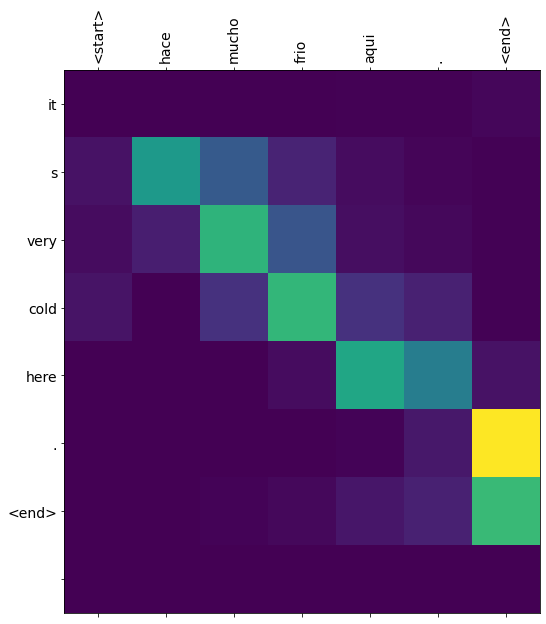

In [70]:
translate(u'Hace mucho frío aquí.')

input: <start> esta es mi vida <end>
predict: this is my life . <end> 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


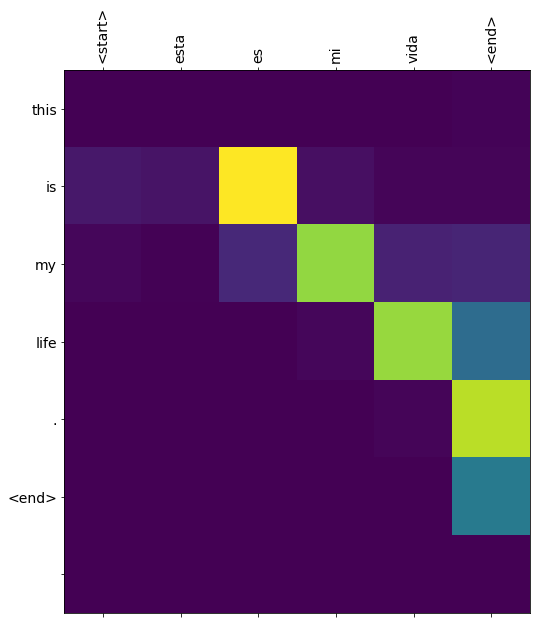

In [71]:
translate(u'esta es mi vida')

input: <start> ¿ sigues en casa ? <end>
predict: are you still home ? <end> 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


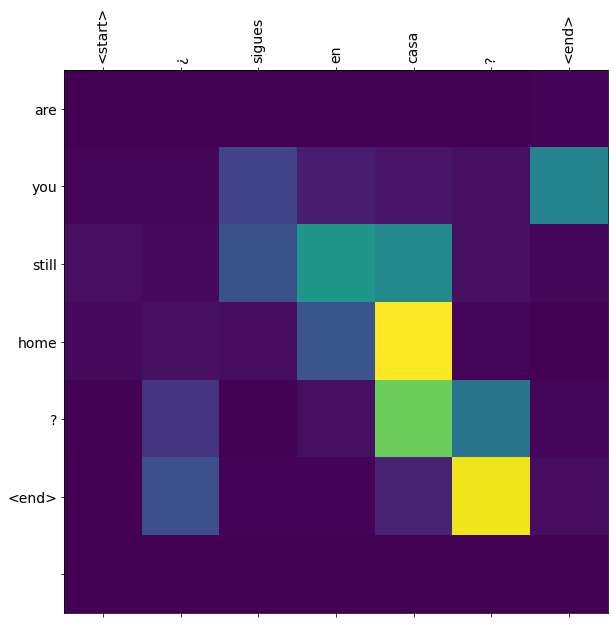

In [72]:
translate(u'¿sigues en casa?')